# Trabajo Práctico N°2 
Asignatura: Minería de Datos.

Carrera: Tecnicatura Universitaria en Inteligencia Artificial.

Año: 2024.

Integrantes:
- López Ceratto, Julieta: L - 3311/1.
- Rodríguez Griñó, Tomás: R - 4643/4

# Librerías.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import random
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.model_selection import cross_val_score


# Funciones a utilizar.

In [2]:
def plot_multiple_conf_matrices(y_real_list, y_pred_list, titles):      
    num_matrices = len(y_real_list)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    # Lista de colormaps para seleccionar aleatoriamente
    colormaps = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'coolwarm', 'cividis', 'magma']
    for i in range(num_matrices):
        color = random.choice(colormaps)
        cm = confusion_matrix(y_real_list[i], y_pred_list[i])
        sns.heatmap(cm, annot=True, ax=axes[i], fmt='d', cmap=color)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')

    # Oculta cualquier eje restante si hay menos de 4 matrices
    for j in range(num_matrices, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [3]:
def pd_metricas_clasifier(dict_modelos: dict, m_type: str = 'clasifier', m: str = None, cv: bool = False, cv_folds: int = 5, model = None, x_list: list = []):
    metricas_modelos = pd.DataFrame()    
    for key, value in dict_modelos.items():
        valores_modelo = value[0]
        
        # Inicializar las métricas como listas
        if m == 'SVM':
            metrica_clas = {
                'Nombre_Modelo': [key],
                'C': [valores_modelo[0]],
                'Kernel': [valores_modelo[1]]
            }
        elif m == 'RandomForest':
            metrica_clas = {
                'Nombre_Modelo': [key],
                'n_estimators': [valores_modelo[0]],
                'criterio': [valores_modelo[1]],
                'max_deph': [valores_modelo[2]],
                'min_samples_split': [valores_modelo[3]],
                'min_samples_leaf': [valores_modelo[4]],
                'max_features': [valores_modelo[5]]
            }
        else:
            metrica_clas = {
                'Nombre_Modelo': [key]
            }
        
        # Métricas de clasificación
        if m_type == 'clasifier':
            if cv:
                # Definir las métricas
                score = {
                        'precision':'precision_macro',
                        'recall': 'recall_macro',
                        'accuracy': make_scorer(accuracy_score),
                        'f1': make_scorer(f1_score, average='macro')
                        }

                for i in range(1, len(value)):
                    y_real, y_pred = value[i]
                    X = x_list[i-1]
                    # Realizar validación cruzada
                    cv_results = cross_validate(model, X, y_real, cv=cv_folds, scoring=score)
                    # Guardar las métricas promedio
                    metrica_clas[f'Precision Test {i}'] = [cv_results['test_precision'].mean()]
                    metrica_clas[f'Recall Test{i}'] = [cv_results['test_recall'].mean()]
                    metrica_clas[f'Accuracy Test{i}'] = [cv_results['test_accuracy'].mean()]
                    metrica_clas[f'F1-Score Test{i}'] = [cv_results['test_f1'].mean()]    

            else:
                for i in range(1, len(value)):
                    y_real, y_pred = value[i]
                    metrica_clas[f'Precision Test {i}'] = [precision_score(y_real, y_pred, pos_label=0, average='macro')]
                    metrica_clas[f'Recall Test {i}'] = [recall_score(y_real, y_pred, pos_label=0, average='macro')]
                    metrica_clas[f'Accuracy Test {i}'] = [accuracy_score(y_real, y_pred)]
                    metrica_clas[f'F1-Score Test {i}'] = [f1_score(y_real, y_pred, pos_label=0, average='macro')]

        # Métricas de regresión
        elif m_type == 'regressor':
            for i in range(1, len(value)):
                y_real, y_pred = value[i]
                metrica_clas[f'MAE Test {i}'] = [mean_absolute_error(y_real, y_pred)]
                metrica_clas[f'MSE Test {i}'] = [mean_squared_error(y_real, y_pred)]
                metrica_clas[f'RMSE Test {i}'] = [np.sqrt(mean_squared_error(y_real, y_pred))]

        # Concatenar el DataFrame de métricas
        metricas_modelos = pd.concat([metricas_modelos, pd.DataFrame(metrica_clas, index=[key])])

    return metricas_modelos


# Carga de datos

In [4]:
clima = pd.read_csv('data\dxWeather.csv')

# Análisis dataset.

Primero analizamos si hay datos faltantes en los 2 datasets

In [5]:
clima

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno
...,...,...,...,...,...,...,...,...
10085,31,24,8.0,5,1029.61,Llanura,Soleado,Verano
10086,29,62,13.0,17,1002.81,Costa,Nublado,Primavera
10087,10,74,14.5,71,1003.15,Montania,Lluvioso,Verano
10088,30,77,5.5,28,1012.69,Costa,Nublado,Otonio


In [6]:
clima.isna().any().any()

False

Revisamos los tipos de datos que poseemos

In [7]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


Luego, vemos y analizamos las distribuciones de los datos numericos del dataset

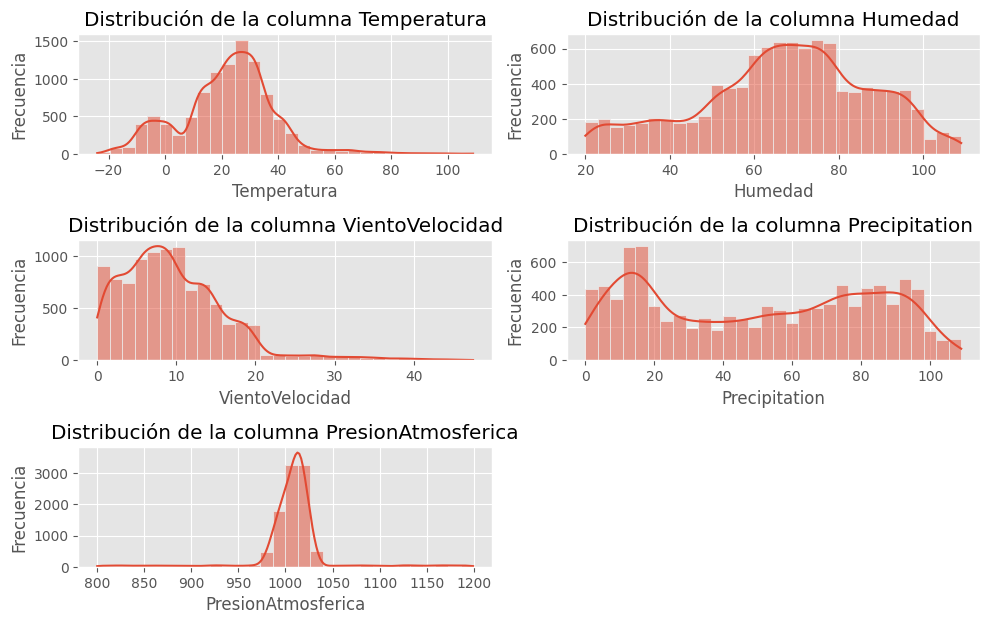

In [8]:
numerical_cols = clima.select_dtypes(include=['float64', 'int64']).columns


n_cols = 2  
n_rows = 5 

plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)  # Crear subgráfica
    sns.histplot(clima[col], bins=30, kde=True)
    plt.title(f"Distribución de la columna {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")


plt.tight_layout()  
plt.show()

### 1. Temperatura
* La distribución de la temperatura parece estar centrada entre aproximadamente 0 y 20 grados, con una ligera asimetría hacia la izquierda (valores negativos).
* La curva KDE (estimación de densidad de núcleo) sugiere que la mayoría de los valores se encuentran entre 0 y 30 grados, con algunos valores extremos hacia el lado negativo, indicando temperaturas bajas, pero estos son menos frecuentes.
* Podría haber valores extremos en la cola izquierda, lo que indica posibles eventos de frío extremo.
### 2. Humedad
* La distribución de la humedad es más bien uniforme, sin un pico muy definido.
* Se observa que la mayor parte de los valores se concentran entre el 60% y el 100%, con algunas fluctuaciones, pero en general, se observa una tendencia de alta humedad.
* Este tipo de distribución puede ser normal en regiones donde la humedad tiende a ser alta durante la mayor parte del tiempo, y sería interesante ver si esto varía estacionalmente.
### 3. Viento Velocidad
* La distribución de la velocidad del viento es asimétrica hacia la derecha, con un pico alrededor de 10 unidades.
* Esto sugiere que la mayoría de las observaciones registran velocidades bajas a moderadas del viento, mientras que las velocidades más altas (más de 30) son poco frecuentes.
* Esta distribución puede indicar que es un área con vientos principalmente moderados, aunque también se presentan algunos eventos de viento fuerte.
### 4. Precipitación
* La precipitación muestra una distribución bastante dispersa, con varios picos.
* La mayoría de los valores están alrededor de 0-20 y luego se extienden con más picos entre 40 y 80, lo que indica una variabilidad en la cantidad de precipitación.
* Esto puede reflejar días con poca lluvia combinados con eventos de lluvias intensas ocasionales. Una inspección adicional por estacionalidad o clima específico podría ayudar a entender mejor esta variabilidad.
### 5. Presión Atmosférica
* La presión atmosférica presenta una distribución muy concentrada alrededor de los 1000 hPa, con una ligera variación.
* Esto es típico, ya que la presión atmosférica no suele fluctuar mucho en condiciones normales, pero pequeñas desviaciones pueden indicar eventos meteorológicos específicos.
* La forma de campana (similar a una distribución normal) sugiere que no hay muchos valores atípicos y que la presión tiende a mantenerse bastante estable en este rango.

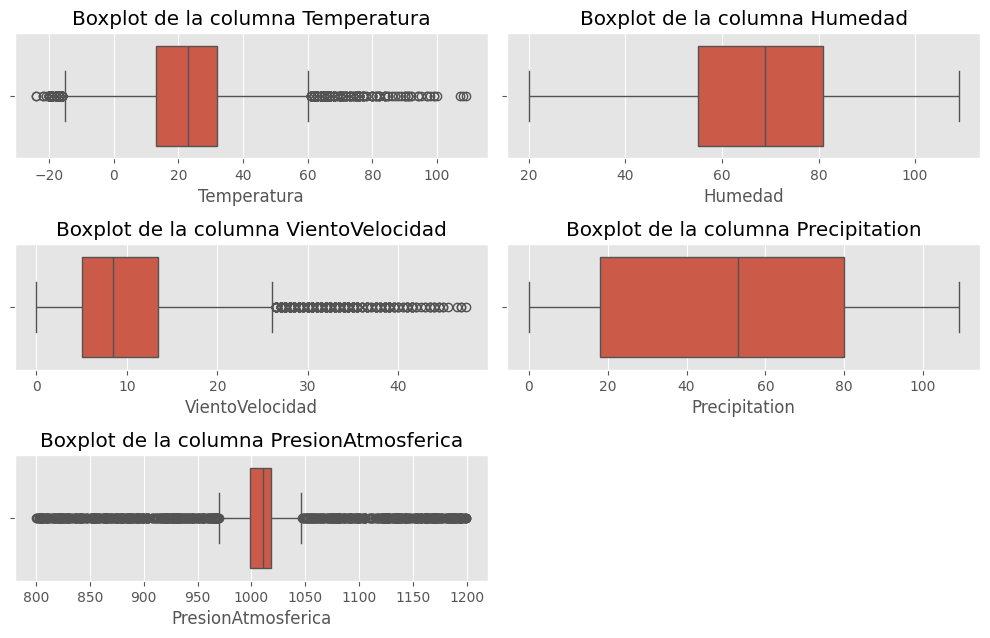

In [9]:
numerical_cols = clima.select_dtypes(include=['float64', 'int64']).columns


n_cols = 2  
n_rows = 5 

plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1 + n_cols)  # Crear boxplot en la siguiente subgráfica
    sns.boxplot(data=clima, x=col)
    plt.title(f"Boxplot de la columna {col}")
    plt.xlabel(col)


plt.tight_layout()  
plt.show()

### 1. Temperatura
* El boxplot muestra que la mayor parte de los valores de temperatura se encuentra entre 0 y 30 grados, lo que coincide con la concentración observada en el histograma anterior.
* Existen varios valores atípicos en el rango superior, alcanzando valores superiores a 80 grados, que parecen ser inusuales y posiblemente anomalías en los datos o eventos extremos.
* También hay valores atípicos en el extremo inferior, con algunas temperaturas menores a -20 grados.
### 2. Humedad
* La humedad tiene una distribución más equilibrada, sin valores atípicos evidentes en los extremos.
* La mayoría de los datos están concentrados entre 60% y 100%, lo cual indica una humedad generalmente alta en los registros.
* La mediana está cerca de 80%, lo que significa que en la mayoría de los casos, los valores de humedad son elevados.
### 3. Viento Velocidad
* La velocidad del viento presenta valores atípicos en el rango superior, con varias observaciones por encima de 20 unidades.
* La mayoría de los valores se concentran por debajo de 15, lo cual indica que los vientos fuertes son poco frecuentes en comparación con vientos de menor velocidad.
* Los outliers en la parte superior sugieren la presencia de algunos eventos de viento muy fuerte, que pueden ser raros o extremos.
### 4. Precipitación
* El boxplot de precipitación muestra una gran dispersión de los datos, sin valores atípicos visibles, lo que indica una variabilidad natural en las cantidades de precipitación.
* La mediana se encuentra cerca del centro del rango, y los datos están distribuidos entre 0 y aproximadamente 100, lo cual refleja tanto días sin lluvia como eventos de precipitación intensa.
* Esta variabilidad sugiere que el dataset cubre tanto eventos de lluvia ligera como fuertes precipitaciones.
### 5. Presión Atmosférica
* La presión atmosférica tiene un rango muy estrecho, con una gran cantidad de valores atípicos en ambos extremos.
* La mayoría de los datos se encuentran alrededor de los 1000 hPa, lo cual es típico para la presión atmosférica en condiciones normales.
* Los outliers en ambos extremos reflejan pequeñas desviaciones de la presión atmosférica estándar, que pueden estar asociadas con cambios meteorológicos o variaciones locales.

# División y preparación Train, Val, Test

In [10]:
X = clima.drop('Estacion', axis = 1)

In [11]:
y = clima['Estacion']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size= 0.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [13]:
(X_train.shape, X_val.shape, X_test.shape)

((6457, 7), (1615, 7), (2018, 7))

In [14]:
## Como son solo 3 los tipos de localización podemos realizar codificación onehot sin que se aumente mucho en dimensionalidad
X_train['Localizacion'].value_counts().unique

<bound method Series.unique of Localizacion
Montania    2273
Llanura     2265
Costa       1919
Name: count, dtype: int64>

In [15]:
## Como son solo 4 los tipos de localización podemos realizar codificación onehot sin que se aumente mucho en dimensionalidad
X_train['TipoClima'].value_counts().unique

<bound method Series.unique of TipoClima
Soleado     1854
Nublado     1789
Lluvioso    1777
Nevado      1037
Name: count, dtype: int64>

In [16]:
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)

# Punto 1: Kernel Lineal.

Realizar la predicción del atributo Estación utilizando máquinas de vectores con kernel lineal analizando el parámetro costo. Mostar los resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k = 5.

## SVM C mediana

In [17]:
svc_model = make_pipeline(StandardScaler(), SVC(C = 0.05, kernel = 'linear', random_state=100))
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.05, kernel='linear', random_state=100))])

In [18]:
y_predict_svc_model = svc_model.predict(X_train)
y_val_predict_svc_model = svc_model.predict(X_val)
y_test_predict_svc_model = svc_model.predict(X_test)

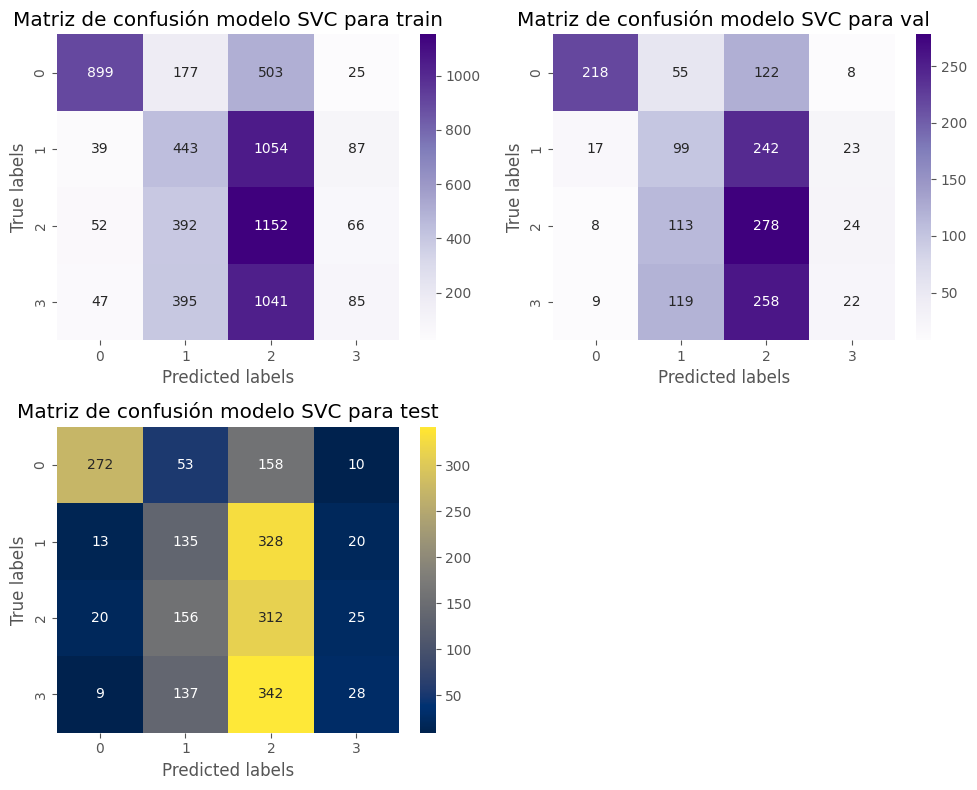

In [19]:
plot_multiple_conf_matrices(
    [y_train,y_val,y_test],
    [y_predict_svc_model,y_val_predict_svc_model,y_test_predict_svc_model],
    ['Matriz de confusión modelo SVC para train', 'Matriz de confusión modelo SVC para val', 'Matriz de confusión modelo SVC para test']
    )

Podemos ver, que las etiquetas se distribuyen de la siguiente forma para las 3 matrices:
- 0: Invierno (se cuenta por fila 1604, 503, 493 predicciones respectivamente)
- 1: Otonio.
- 2: Primavera.
- 3: Verano.

La primera matriz (datos Train):
 - Para la clase 0 (invierno): de los 1604 datos, solo predice bien 899, es decir un poco más del 50% por lo que se asemeja a un rendiiento cara-cruz aleatorio.
 - Para la etiqueta 1 (Otoño): de los 1623 datos, predice bien sólo 443, por lo que es un rendimiento bajo.
 - Para la etiqueta 2 (Primavera); de los 1662 datos, predice bien 1152 lo cual es muy bueno.
 - Para la etiqueta 3 (Verano): de los 1568 datos, predice bien sólo 85, siendo esta la etiqueta con un rendimiento más bajo.
 Se ve una tendencia general a predecir la etiqueta 2 (es decir, a la estación Primavera)

Con las otras dos matrices (validación y test) se ve cómo se replica esta performance.

Esto se pude deber a que la C es muy baja, es decir tiene una rigurización que no es suficiente para separar bien los datos y hacer predicciones más uniformes entre las clases.

In [20]:
pd.DataFrame(y_train).value_counts().unique, pd.DataFrame(y_val).value_counts().unique , pd.DataFrame(y_test).value_counts().unique

(<bound method Series.unique of Primavera    1662
 Otonio       1623
 Invierno     1604
 Verano       1568
 Name: count, dtype: int64>,
 <bound method Series.unique of Primavera    423
 Verano       408
 Invierno     403
 Otonio       381
 Name: count, dtype: int64>,
 <bound method Series.unique of Verano       516
 Primavera    513
 Otonio       496
 Invierno     493
 Name: count, dtype: int64>)

In [21]:
metricas_svc = pd_metricas_clasifier(
    {'SVC 1': [
        [0.05,'Linear'],
        (y_train,y_predict_svc_model),
        (y_val, y_val_predict_svc_model),
        (y_test,y_test_predict_svc_model)]},
    m_type= 'clasifier',
    m = 'SVM',
    cv= True,
    x_list= [X_train,X_val, X_test],
    model= svc_model
)

In [22]:
metricas_svc

,Nombre_Modelo,C,Kernel,Precision Test 1,Recall Test1,Accuracy Test1,F1-Score Test1,Precision Test 2,Recall Test2,Accuracy Test2,F1-Score Test2,Precision Test 3,Recall Test3,Accuracy Test3,F1-Score Test3
SVC 1,SVC 1,0.05,Linear,0.456392,0.391956,0.39585,0.370591,0.487,0.390357,0.395666,0.378904,0.423881,0.388862,0.390479,0.370556


## Cambiando parámetro C

### C menor

In [23]:
svc_model_2 = make_pipeline(StandardScaler(), SVC(C = 0.001, kernel = 'linear', random_state=70))
svc_model_2.fit(X_train, y_train)
y_predict_svc_model_2 = svc_model_2.predict(X_train)
y_val_predict_svc_model_2 = svc_model_2.predict(X_val)
y_test_predict_svc_model_2 = svc_model_2.predict(X_test)

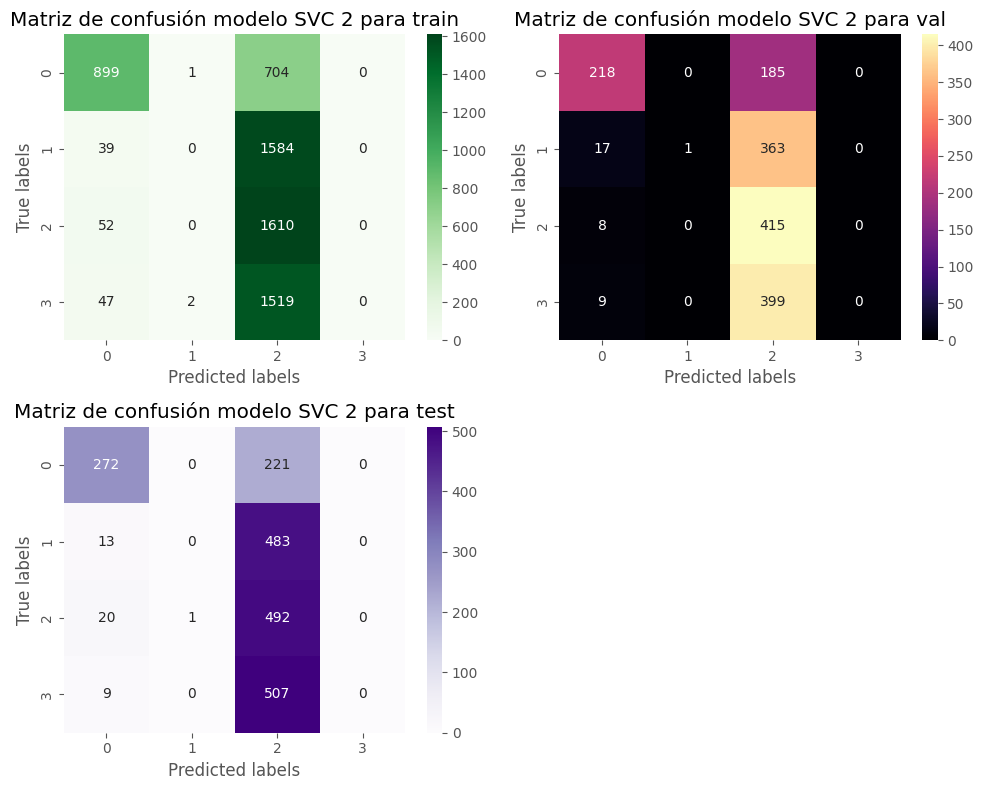

In [24]:
plot_multiple_conf_matrices(
    [y_train,y_val,y_test],
    [y_predict_svc_model_2,y_val_predict_svc_model_2,y_test_predict_svc_model_2],
    ['Matriz de confusión modelo SVC 2 para train', 'Matriz de confusión modelo SVC 2 para val', 'Matriz de confusión modelo SVC 2 para test']
    )

Con un valor de C menor, la rigurización es menor y se ve cómo tiene a clasificar hacia la clase mayoritaria, algo casi similar en cuanto a performance con lo que pasaría en un Bayes.

In [25]:
metricas_svc = pd.concat(
[metricas_svc,
 pd_metricas_clasifier(
     {'SVC 2': [
         [0.001, 'Linear'],
         (y_train,y_predict_svc_model_2),
         (y_val, y_val_predict_svc_model_2),
         (y_test,y_test_predict_svc_model_2)
         ]
    },
    m_type= 'clasifier',
    m = 'SVM',
    cv= True,
    x_list= [X_train,X_val, X_test],
    model= svc_model_2
)])

In [26]:
metricas_svc

,Nombre_Modelo,C,Kernel,Precision Test 1,Recall Test1,Accuracy Test1,F1-Score Test1,Precision Test 2,Recall Test2,Accuracy Test2,F1-Score Test2,Precision Test 3,Recall Test3,Accuracy Test3,F1-Score Test3
SVC 1,SVC 1,0.050,Linear,0.456392,0.391956,0.395850,0.370591,0.487000,0.390357,0.395666,0.378904,0.423881,0.388862,0.390479,0.370556
SVC 2,SVC 2,0.001,Linear,0.291058,0.382297,0.388571,0.283871,0.294182,0.380541,0.391950,0.282969,0.290494,0.383499,0.386008,0.282106


### C mayor

In [27]:
svc_model_3 = make_pipeline(StandardScaler(), SVC(C = 10, kernel = 'linear', random_state=90))
svc_model_3.fit(X_train, y_train)
y_predict_svc_model_3 = svc_model_3.predict(X_train)
y_val_predict_svc_model_3 = svc_model_3.predict(X_val)
y_test_predict_svc_model_3 = svc_model_3.predict(X_test)

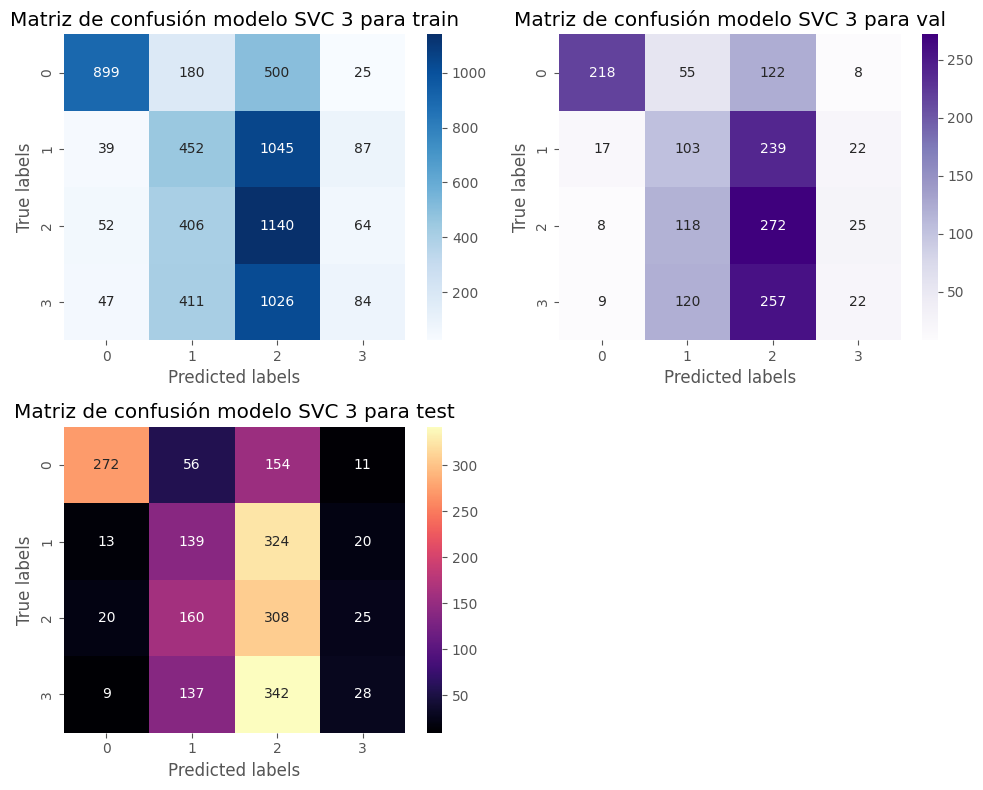

In [28]:
plot_multiple_conf_matrices(
    [y_train,y_val,y_test],
    [y_predict_svc_model_3,y_val_predict_svc_model_3,y_test_predict_svc_model_3],
    ['Matriz de confusión modelo SVC 3 para train', 'Matriz de confusión modelo SVC 3 para val', 'Matriz de confusión modelo SVC 3 para test']
    )

Parece tener un tope en cuanto a rendimiento, ya que por mas riguroso que se haga no puede quitar su tendencia a predecir la clase 2.

In [29]:
metricas_svc = pd.concat(
[metricas_svc,
 pd_metricas_clasifier(
     {'SVC 3': [
         [10, 'Lineal'],
         (y_train,y_predict_svc_model_3),
         (y_val, y_val_predict_svc_model_3),
         (y_test,y_test_predict_svc_model_3)
         ]
    }, m_type= 'clasifier', m = 'SVM',
    cv = True,
    model = svc_model_3,
    x_list=[X_train,X_val, X_test]
)])

In [30]:
metricas_svc

,Nombre_Modelo,C,Kernel,Precision Test 1,Recall Test1,Accuracy Test1,F1-Score Test1,Precision Test 2,Recall Test2,Accuracy Test2,F1-Score Test2,Precision Test 3,Recall Test3,Accuracy Test3,F1-Score Test3
SVC 1,SVC 1,0.050,Linear,0.456392,0.391956,0.395850,0.370591,0.487000,0.390357,0.395666,0.378904,0.423881,0.388862,0.390479,0.370556
SVC 2,SVC 2,0.001,Linear,0.291058,0.382297,0.388571,0.283871,0.294182,0.380541,0.391950,0.282969,0.290494,0.383499,0.386008,0.282106
SVC 3,SVC 3,10.000,Lineal,0.458128,0.393416,0.397244,0.373323,0.448255,0.385344,0.390093,0.376742,0.419844,0.386500,0.387992,0.371435


Lo comentado anteriormente también se puede ver en su Accuracy para train (Test 1), ya que es similar al del primer modelo con C = 0.05.

Estos rendimientos se pueden deber a que se está trabajando con un kernel lineal, el cual no pareciera ser suficiente a la hora de espaciar las clases.1

# Punto 2: Kernel Gaussiano.

Realizar la predicción del atributo Estación utilizando máquinas de vectores con kernel gaussiano analizando los parámetros costo y gama. Mostar los resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k = 5.

In [34]:
# Función objetivo para Optuna
def objective(trial):
    # Sugerir valores para los hiperparámetros
    C = trial.suggest_float('C', 0, 40 , step = 0.5) 
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e1)  # Escala logarítmica para gamma
    
    # Crear el pipeline
    model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=C, gamma=gamma, random_state=42))
    
    # Validación cruzada en el conjunto de entrenamiento
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='precision_macro').mean()
    
    return score

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=10)  

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(study.best_params)

# Entrenar el modelo final con los mejores parámetros
best_params = study.best_params
best_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42))
best_model.fit(X_train, y_train)

# Evaluar el modelo en los conjuntos de validación y prueba
y_val_predict = best_model.predict(X_val)
y_test_predict = best_model.predict(X_test)

best_C = study.best_params['C']
best_gamma = study.best_params['gamma']


[I 2024-11-24 09:50:31,930] A new study created in memory with name: no-name-1b569b61-ba87-4942-8a5a-26a9b7d3d9c1
[I 2024-11-24 09:50:44,464] Trial 0 finished with value: 0.36688895495753376 and parameters: {'C': 37.0, 'gamma': 7.733172157515222}. Best is trial 0 with value: 0.36688895495753376.
[I 2024-11-24 09:50:57,056] Trial 1 finished with value: 0.4001151917073652 and parameters: {'C': 31.0, 'gamma': 0.4060441461998468}. Best is trial 1 with value: 0.4001151917073652.
[I 2024-11-24 09:51:06,754] Trial 2 finished with value: 0.4524405545133132 and parameters: {'C': 29.0, 'gamma': 0.0010777253775971995}. Best is trial 2 with value: 0.4524405545133132.
[I 2024-11-24 09:51:18,056] Trial 3 finished with value: 0.42548537407590015 and parameters: {'C': 32.0, 'gamma': 0.1455596880493223}. Best is trial 2 with value: 0.4524405545133132.
[I 2024-11-24 09:51:28,870] Trial 4 finished with value: 0.4568020952404984 and parameters: {'C': 20.5, 'gamma': 0.026161184995254137}. Best is trial 4 w

Mejores parámetros encontrados:
{'C': 20.5, 'gamma': 0.026161184995254137}


In [35]:
# Crear el pipeline con SVM y kernel gaussiano
model_svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=best_C, gamma=best_gamma, random_state=42))

# Entrenar el modelo
model_svm.fit(X_train, y_train)

# Hacer predicciones
y_train_predict_model_svm = model_svm.predict(X_train)
y_val_predict_model_svm = model_svm.predict(X_val)
y_test_predict_model_svm = model_svm.predict(X_test)

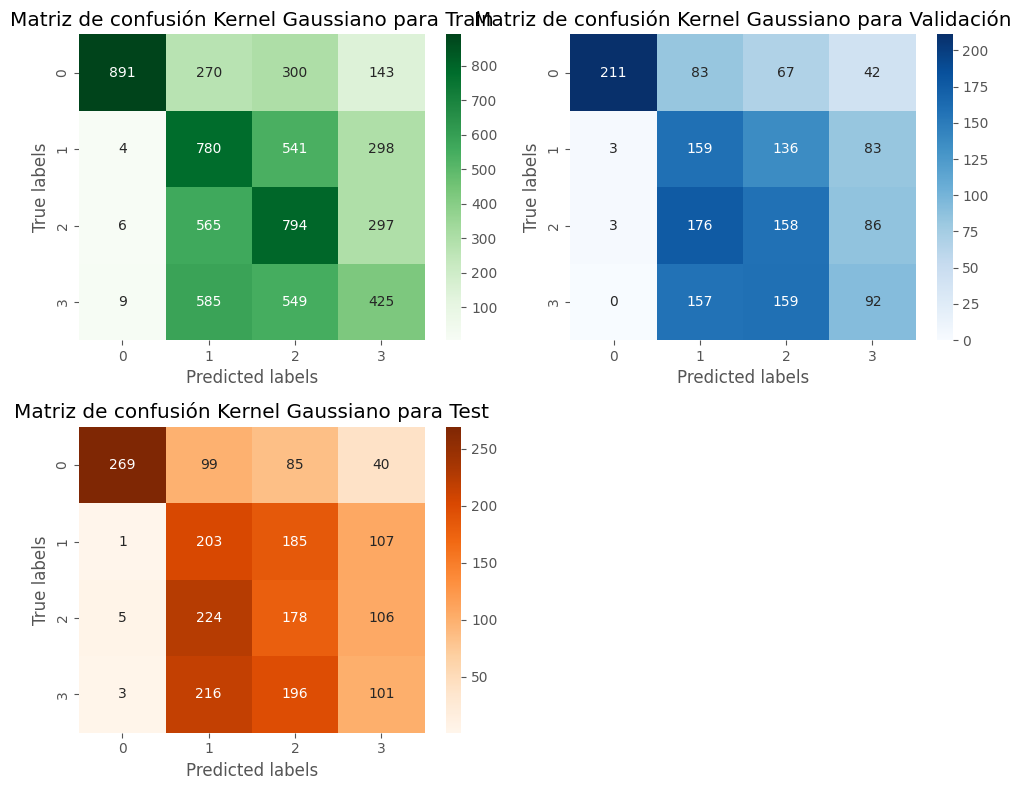

In [41]:
plot_multiple_conf_matrices(
    [y_train, y_val,y_test],
    [y_train_predict_model_svm, y_val_predict_model_svm, y_test_predict_model_svm],
    ['Matriz de confusión Kernel Gaussiano para Train', 'Matriz de confusión Kernel Gaussiano para Validación', 'Matriz de confusión Kernel Gaussiano para Test']
    )

In [48]:
np.unique(y_train, return_counts=True)

(array(['Invierno', 'Otonio', 'Primavera', 'Verano'], dtype=object),
 array([1604, 1623, 1662, 1568], dtype=int64))

- Clase 0: Invierno (1604 datos)
- Clase 1: Otonio (1623 datos)
- Clase 2: Primavera (1662 datos)
- Clase 3: Verano (1568 datos)

En cuanto a la primera matriz (train) se observa que los verdaderos positivos son los mayoritarios para cada clase, sin embargo, diferencia mejor la clase 0 (Invierno) que a las otras; encontrandose en estas un número menor de falsos positivos (columna 0, posiciones de 1-3) frente a los verdaderos positivos (columna 0, posición 0). Este comportamiento se replica en los conjuntos de Validación y de Test.

In [49]:
# Calcular las métricas
precision = precision_score(y_test, y_test_predict_model_svm, average=None)
recall = recall_score(y_test, y_test_predict_model_svm, average=None)
f1 = f1_score(y_test, y_test_predict_model_svm, average=None)
accuracy = accuracy_score(y_test, y_test_predict_model_svm)

# Mostrar las métricas para cada clase
etiquetas = ['Invierno', 'Otoño', 'Primavera', 'Verano']
for i, etiqueta in enumerate(etiquetas):
    print(f"{etiqueta}:")
    print(f"  Precisión: {precision[i]:.2f}")
    print(f"  Exhaustividad (Recall): {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print()

# Mostrar la exactitud global
print(f"Exactitud (Accuracy): {accuracy:.4f}")


Invierno:
  Precisión: 0.97
  Exhaustividad (Recall): 0.55
  F1-Score: 0.70

Otoño:
  Precisión: 0.27
  Exhaustividad (Recall): 0.41
  F1-Score: 0.33

Primavera:
  Precisión: 0.28
  Exhaustividad (Recall): 0.35
  F1-Score: 0.31

Verano:
  Precisión: 0.29
  Exhaustividad (Recall): 0.20
  F1-Score: 0.23

Exactitud (Accuracy): 0.3722


La exactitud muestra que el modelo tiene un 37.26% de predicciones correctas considerando todas las estaciones. Esto es relativamente bajo y refleja que, aunque el modelo predice "Invierno" con mayor precisión, su desempeño global es insuficiente debido al pobre desempeño en las otras estaciones. Tal como se veía en la matriz de confusión.

In [50]:
metricas_svc_gaus = pd_metricas_clasifier(
     {'SVC Gaus': [
         [20.5, 'Gaussiano con gamma: 0.026161184995254137 '],
         (y_train,y_train_predict_model_svm),
         (y_val, y_val_predict_model_svm),
         (y_test,y_test_predict_model_svm)
         ]
    }, m_type= 'clasifier', m = 'SVM',
    cv = True,
    model = svc_model_3,
    x_list=[X_train,X_val, X_test]
)

In [51]:
metricas_svc_gaus

,Nombre_Modelo,C,Kernel,Precision Test 1,Recall Test1,Accuracy Test1,F1-Score Test1,Precision Test 2,Recall Test2,Accuracy Test2,F1-Score Test2,Precision Test 3,Recall Test3,Accuracy Test3,F1-Score Test3
SVC Gaus,SVC Gaus,20.5,Gaussiano con gamma: 0.026161184995254137,0.458128,0.393416,0.397244,0.373323,0.448255,0.385344,0.390093,0.376742,0.419844,0.3865,0.387992,0.371435


### Conclusión SVM con Kernel Gaussiano

Aparentemente, a pesar de usar un kernel gaussiano, el modelo aún tiene problemas para diferenciar bien las clases y no se observa una mejora significativa en la precisión macro del modelo respecto a SVM con kernel lineal.

# Punto 3: Random Forest.

Realizar la predicción del atributo Estación utilizando Random Forest analizando los parámetros cantidad de estimadores y la máxima profundidad de los  rboles. Mostar los resultados sobre los conjuntos de test (Precisión, Exhaustividad y Exactitud) utilizando validación cruzada con k = 5.

In [62]:
model_rf = make_pipeline(StandardScaler(), RandomForestClassifier())
model_rf.fit(X_train,y_train)
y_train_predict_model_rf = model_rf.predict(X_train)
y_val_predict_model_rf = model_rf.predict(X_val)
y_test_predict_model_rf = model_rf.predict(X_test)

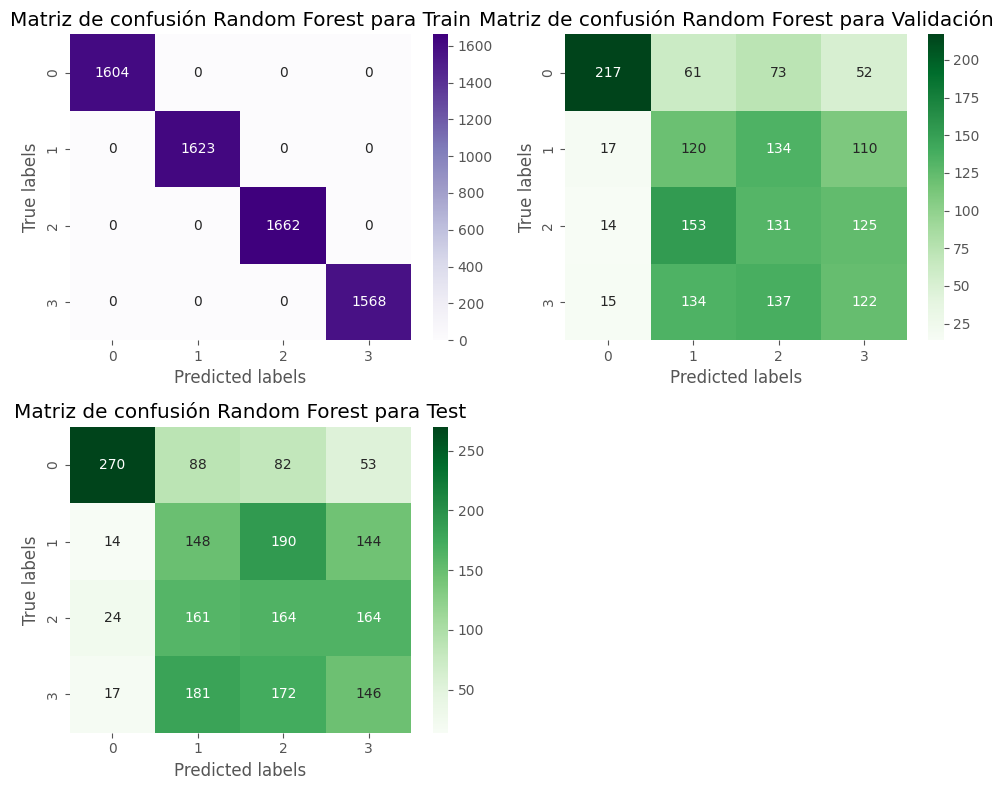

In [63]:
plot_multiple_conf_matrices(
    [y_train, y_val,y_test],
    [y_train_predict_model_rf, y_val_predict_model_rf, y_test_predict_model_rf],
    ['Matriz de confusión Random Forest para Train', 'Matriz de confusión Random Forest para Validación', 'Matriz de confusión Random Forest para Test']
    )

Podemos ver, que las etiquetas se distribuyen de la siguiente forma para las 3 matrices:
- 0: Invierno (se cuenta por fila 1604, 503, 493 predicciones respectivamente)
- 1: Otonio.
- 2: Primavera.
- 3: Verano.

Podemos ver una clasificación perfecta en la matriz de Train; sin embargo, el modelo parece estar sobreajustando ya que su performance en Validación y Test es significativamente menor. Esto se debe posiblemente a que el parámetro por defecto 'n_estimators', es decir la cantidad de árboles, es 100 lo cual parece ser mucho para este problema. 

In [64]:
X_train.shape

(6457, 12)

In [65]:
y_val.shape

(1615, 1)

In [66]:
metricas_random_forest = pd_metricas_clasifier(
    {'Random Forest 1':[
     [100, 'gini', None, 2, 1, 'sqr'],
     (y_train, y_train_predict_model_rf),
     (y_val, y_val_predict_model_rf),
     (y_test, y_test_predict_model_rf)
     ]
    },
    m = 'RandomForest',
    cv = False,
    cv_folds= 5,
    model = model_rf,
    x_list=[X_train,X_val, X_test]
)

In [67]:
metricas_random_forest

,Nombre_Modelo,n_estimators,criterio,max_deph,min_samples_split,min_samples_leaf,max_features,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
Random Forest 1,Random Forest 1,100,gini,None,2,1,sqr,1.0,1.0,1.0,1.0,0.413896,0.365534,0.365325,0.381188,0.411132,0.362172,0.360753,0.378446


## Cambiando cantidad de estimadores y maxima profundidad

### N_estimators muy bajo

In [68]:
model_rf_2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators= 10, max_depth=None))
model_rf_2.fit(X_train,y_train)
y_train_predict_model_rf_2 = model_rf_2.predict(X_train)
y_val_predict_model_rf_2 = model_rf_2.predict(X_val)
y_test_predict_model_rf_2 = model_rf_2.predict(X_test)

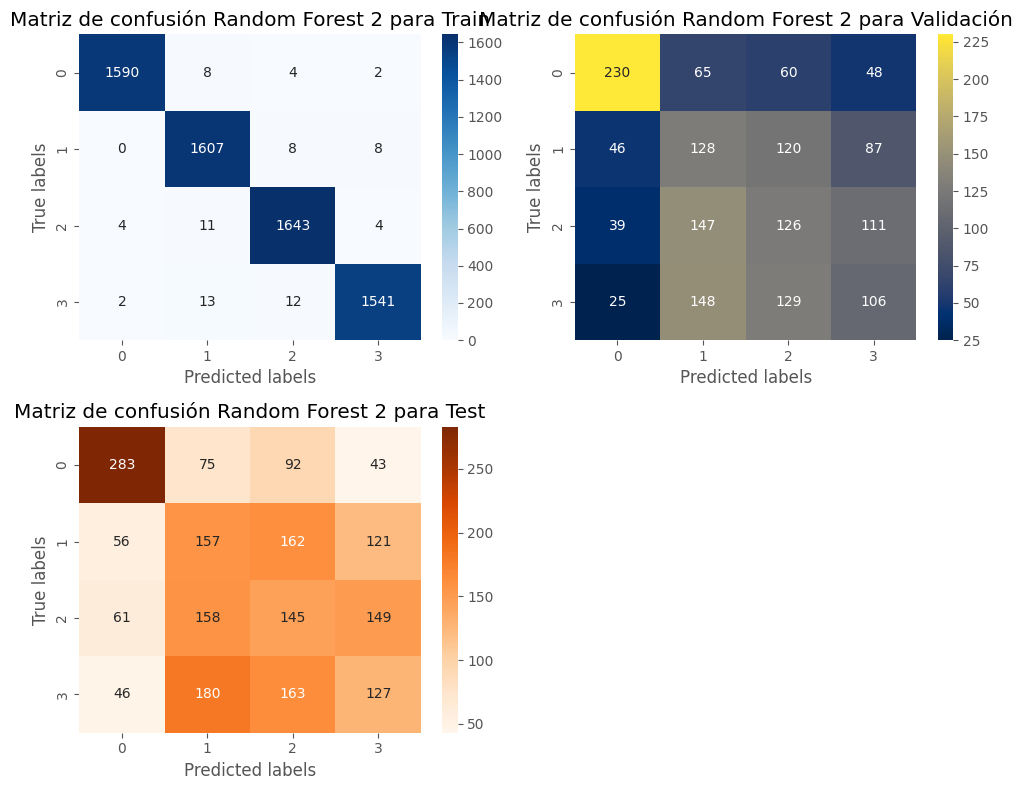

In [69]:
plot_multiple_conf_matrices(
    [y_train, y_val,y_test],
    [y_train_predict_model_rf_2, y_val_predict_model_rf_2, y_test_predict_model_rf_2],
    ['Matriz de confusión Random Forest 2 para Train', 'Matriz de confusión Random Forest 2 para Validación', 'Matriz de confusión Random Forest 2 para Test']
    )

In [70]:
metricas_random_forest = pd.concat([ metricas_random_forest, pd_metricas_clasifier(
    {'Random Forest 2':[
     [10, 'gini', None, 2, 1, 'sqr'],
     (y_train, y_train_predict_model_rf_2),
     (y_val, y_val_predict_model_rf_2),
     (y_test, y_test_predict_model_rf_2)
     ]
    },
    m = 'RandomForest',
    cv = False,
    cv_folds= 5,
    model = model_rf_2,
    x_list=[X_train,X_val, X_test]
) ])

In [71]:
metricas_random_forest

,Nombre_Modelo,n_estimators,criterio,max_deph,min_samples_split,min_samples_leaf,max_features,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
Random Forest 1,Random Forest 1,100,gini,None,2,1,sqr,1.000000,1.000000,1.00000,1.000000,0.413896,0.365534,0.365325,0.381188,0.411132,0.362172,0.360753,0.378446
Random Forest 2,Random Forest 2,10,gini,None,2,1,sqr,0.988329,0.988191,0.98823,0.988247,0.382389,0.366088,0.365325,0.371589,0.364153,0.354836,0.352825,0.358196


### Max_depth muy baja

In [72]:
model_rf_3 = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=5))
model_rf_3.fit(X_train,y_train)
y_train_predict_model_rf_3 = model_rf_3.predict(X_train)
y_val_predict_model_rf_3 = model_rf_3.predict(X_val)
y_test_predict_model_rf_3 = model_rf_3.predict(X_test)

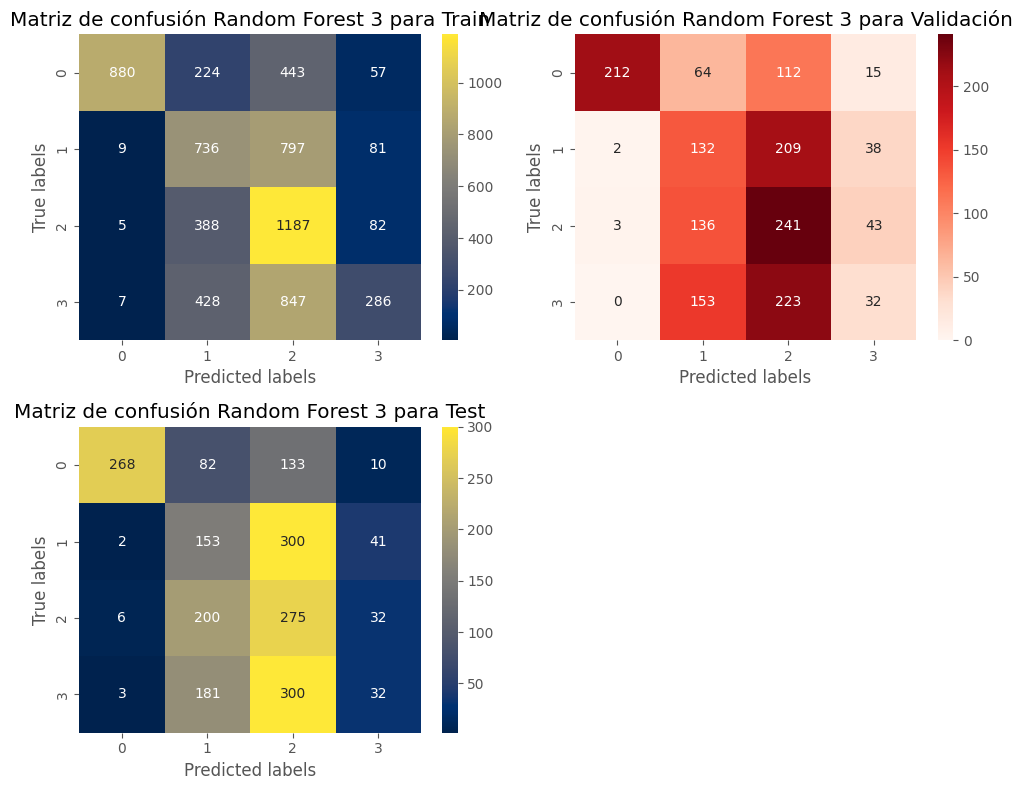

In [73]:
plot_multiple_conf_matrices(
    [y_train, y_val,y_test],
    [y_train_predict_model_rf_3, y_val_predict_model_rf_3, y_test_predict_model_rf_3],
    ['Matriz de confusión Random Forest 3 para Train', 'Matriz de confusión Random Forest 3 para Validación', 'Matriz de confusión Random Forest 3 para Test']
    )

In [74]:
metricas_random_forest = pd.concat([ metricas_random_forest, pd_metricas_clasifier(
    {'Random Forest 3':[
     [100, 'gini', 5, 2, 1, 'sqr'],
     (y_train, y_train_predict_model_rf_3),
     (y_val, y_val_predict_model_rf_3),
     (y_test, y_test_predict_model_rf_3)
     ]
    },
    m = 'RandomForest',
    cv = False,
    cv_folds= 5,
    model = model_rf_3,
    x_list=[X_train,X_val, X_test]
) ])
metricas_random_forest

,Nombre_Modelo,n_estimators,criterio,max_deph,min_samples_split,min_samples_leaf,max_features,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
Random Forest 1,Random Forest 1,100,gini,None,2,1,sqr,1.000000,1.000000,1.000000,1.000000,0.413896,0.365534,0.365325,0.381188,0.411132,0.362172,0.360753,0.378446
Random Forest 2,Random Forest 2,10,gini,None,2,1,sqr,0.988329,0.988191,0.988230,0.988247,0.382389,0.366088,0.365325,0.371589,0.364153,0.354836,0.352825,0.358196
Random Forest 3,Random Forest 3,100,gini,5,2,1,sqr,0.579719,0.474677,0.478396,0.473104,0.451532,0.380171,0.382043,0.376783,0.440007,0.362539,0.360753,0.358128


### Max_depth y n_estimators bajos

In [75]:
model_rf_4 = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=5, n_estimators=10))
model_rf_4.fit(X_train,y_train)
y_train_predict_model_rf_4 = model_rf_4.predict(X_train)
y_val_predict_model_rf_4 = model_rf_4.predict(X_val)
y_test_predict_model_rf_4 = model_rf_4.predict(X_test)

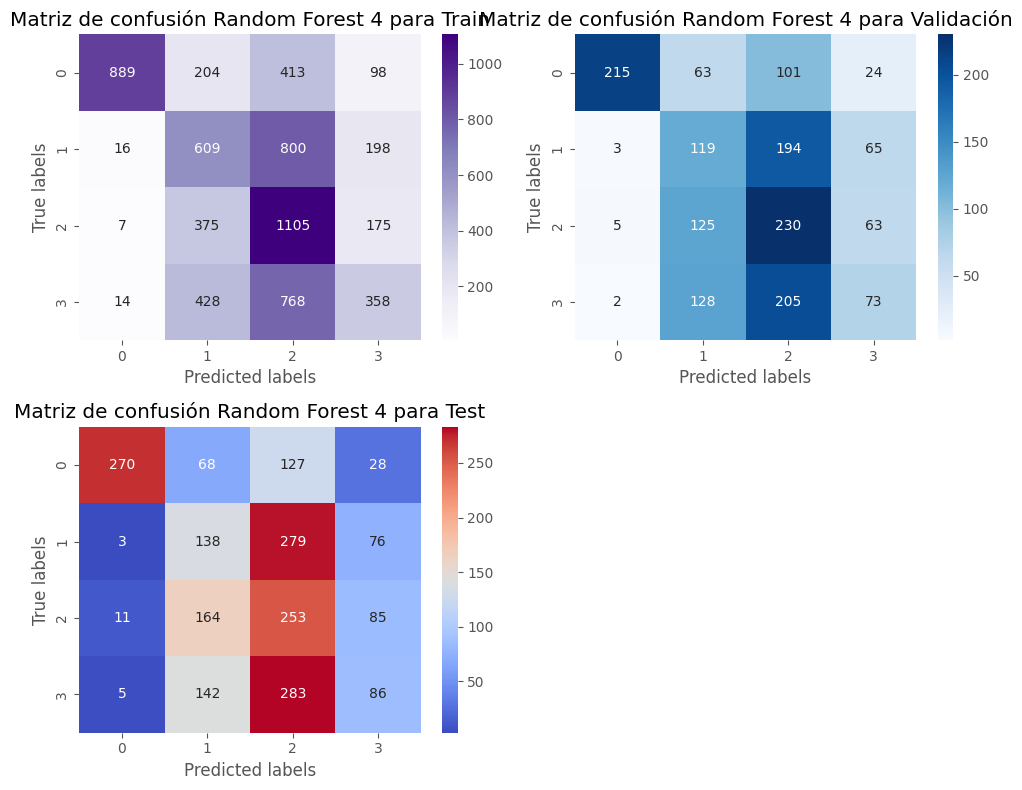

In [76]:
plot_multiple_conf_matrices(
    [y_train, y_val,y_test],
    [y_train_predict_model_rf_4, y_val_predict_model_rf_4, y_test_predict_model_rf_4],
    ['Matriz de confusión Random Forest 4 para Train', 'Matriz de confusión Random Forest 4 para Validación', 'Matriz de confusión Random Forest 4 para Test']
    )

In [77]:
metricas_random_forest = pd.concat([ metricas_random_forest, pd_metricas_clasifier(
    {'Random Forest 4':[
     [10, 'gini', 5, 2, 1, 'sqr'],
     (y_train, y_train_predict_model_rf_4),
     (y_val, y_val_predict_model_rf_4),
     (y_test, y_test_predict_model_rf_4)
     ]
    },
    m = 'RandomForest',
    cv = False,
    cv_folds= 5,
    model = model_rf_4,
    x_list=[X_train,X_val, X_test]
) ])
metricas_random_forest

,Nombre_Modelo,n_estimators,criterio,max_deph,min_samples_split,min_samples_leaf,max_features,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
Random Forest 1,Random Forest 1,100,gini,None,2,1,sqr,1.000000,1.000000,1.000000,1.000000,0.413896,0.365534,0.365325,0.381188,0.411132,0.362172,0.360753,0.378446
Random Forest 2,Random Forest 2,10,gini,None,2,1,sqr,0.988329,0.988191,0.988230,0.988247,0.382389,0.366088,0.365325,0.371589,0.364153,0.354836,0.352825,0.358196
Random Forest 3,Random Forest 3,100,gini,5,2,1,sqr,0.579719,0.474677,0.478396,0.473104,0.451532,0.380171,0.382043,0.376783,0.440007,0.362539,0.360753,0.358128
Random Forest 4,Random Forest 4,10,gini,5,2,1,sqr,0.531703,0.455662,0.458572,0.460744,0.467158,0.392123,0.394427,0.401497,0.446273,0.371434,0.370168,0.382390


### Con tunning de hiperparámetros

Utilizamos optuna para encontrar los mejores hiperparámetros.

In [78]:

def objective(trial):
    # Sugerir valores para n_estimators y max_depth
    estimators = trial.suggest_int('n_estimators', 5, 500, 5)
    m_depth = trial.suggest_int('max_depth', 5, 50, 5)

    # Instanciar el modelo con los hiperparámetros sugeridos
    modelo_optuna = RandomForestClassifier(n_estimators=estimators, max_depth=m_depth)

    # Realizar validación cruzada
    cv_results = cross_validate(modelo_optuna, X_val, y_val, cv=5, scoring='precision_macro')
    
    # Obtener la precisión promedio
    mean_precision = cv_results['test_score'].mean()

    # Imprimir los resultados
    print(f"Trial {trial.number}: precision={mean_precision:.4f}, n_estimators = {estimators}, max_depth = {m_depth}")

    # Devolver la precisión media
    return mean_precision

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Obtener los mejores parámetros y la mejor precisión
best_params_optuna = study.best_params
best_value_optuna = study.best_value

print("Mejores hiperparámetros encontrados:", best_params_optuna)
print("Mejor precisión:", best_value_optuna)

[I 2024-11-24 10:14:50,792] A new study created in memory with name: no-name-aa395ca6-0dab-45fa-beab-e9293b3b803e
[I 2024-11-24 10:14:51,426] Trial 0 finished with value: 0.41047111665608826 and parameters: {'n_estimators': 50, 'max_depth': 15}. Best is trial 0 with value: 0.41047111665608826.


Trial 0: precision=0.4105, n_estimators = 50, max_depth = 15


[I 2024-11-24 10:14:53,269] Trial 1 finished with value: 0.40601044463279434 and parameters: {'n_estimators': 140, 'max_depth': 25}. Best is trial 0 with value: 0.41047111665608826.


Trial 1: precision=0.4060, n_estimators = 140, max_depth = 25


[I 2024-11-24 10:14:55,186] Trial 2 finished with value: 0.43889867094875895 and parameters: {'n_estimators': 175, 'max_depth': 10}. Best is trial 2 with value: 0.43889867094875895.


Trial 2: precision=0.4389, n_estimators = 175, max_depth = 10


[I 2024-11-24 10:15:00,601] Trial 3 finished with value: 0.40261841099939 and parameters: {'n_estimators': 435, 'max_depth': 20}. Best is trial 2 with value: 0.43889867094875895.


Trial 3: precision=0.4026, n_estimators = 435, max_depth = 20


[I 2024-11-24 10:15:04,095] Trial 4 finished with value: 0.40987867126281774 and parameters: {'n_estimators': 280, 'max_depth': 50}. Best is trial 2 with value: 0.43889867094875895.


Trial 4: precision=0.4099, n_estimators = 280, max_depth = 50


[I 2024-11-24 10:15:04,612] Trial 5 finished with value: 0.3828288625820755 and parameters: {'n_estimators': 40, 'max_depth': 35}. Best is trial 2 with value: 0.43889867094875895.


Trial 5: precision=0.3828, n_estimators = 40, max_depth = 35


[I 2024-11-24 10:15:08,045] Trial 6 finished with value: 0.43033678843416795 and parameters: {'n_estimators': 345, 'max_depth': 10}. Best is trial 2 with value: 0.43889867094875895.


Trial 6: precision=0.4303, n_estimators = 345, max_depth = 10


[I 2024-11-24 10:15:08,953] Trial 7 finished with value: 0.43625079405289513 and parameters: {'n_estimators': 90, 'max_depth': 10}. Best is trial 2 with value: 0.43889867094875895.


Trial 7: precision=0.4363, n_estimators = 90, max_depth = 10


[I 2024-11-24 10:15:11,861] Trial 8 finished with value: 0.4329919707047292 and parameters: {'n_estimators': 295, 'max_depth': 10}. Best is trial 2 with value: 0.43889867094875895.


Trial 8: precision=0.4330, n_estimators = 295, max_depth = 10


[I 2024-11-24 10:15:12,711] Trial 9 finished with value: 0.4031274409537152 and parameters: {'n_estimators': 70, 'max_depth': 35}. Best is trial 2 with value: 0.43889867094875895.


Trial 9: precision=0.4031, n_estimators = 70, max_depth = 35


[I 2024-11-24 10:15:14,215] Trial 10 finished with value: 0.4535760589094113 and parameters: {'n_estimators': 190, 'max_depth': 5}. Best is trial 10 with value: 0.4535760589094113.


Trial 10: precision=0.4536, n_estimators = 190, max_depth = 5


[I 2024-11-24 10:15:15,802] Trial 11 finished with value: 0.4481745347132266 and parameters: {'n_estimators': 190, 'max_depth': 5}. Best is trial 10 with value: 0.4535760589094113.


Trial 11: precision=0.4482, n_estimators = 190, max_depth = 5


[I 2024-11-24 10:15:17,461] Trial 12 finished with value: 0.44753854900641665 and parameters: {'n_estimators': 195, 'max_depth': 5}. Best is trial 10 with value: 0.4535760589094113.


Trial 12: precision=0.4475, n_estimators = 195, max_depth = 5


[I 2024-11-24 10:15:19,343] Trial 13 finished with value: 0.45331105940843 and parameters: {'n_estimators': 225, 'max_depth': 5}. Best is trial 10 with value: 0.4535760589094113.


Trial 13: precision=0.4533, n_estimators = 225, max_depth = 5


[I 2024-11-24 10:15:24,455] Trial 14 finished with value: 0.3976124073107595 and parameters: {'n_estimators': 375, 'max_depth': 20}. Best is trial 10 with value: 0.4535760589094113.


Trial 14: precision=0.3976, n_estimators = 375, max_depth = 20


[I 2024-11-24 10:15:31,069] Trial 15 finished with value: 0.40485499792294044 and parameters: {'n_estimators': 500, 'max_depth': 35}. Best is trial 10 with value: 0.4535760589094113.


Trial 15: precision=0.4049, n_estimators = 500, max_depth = 35


[I 2024-11-24 10:15:34,503] Trial 16 finished with value: 0.3965990069700062 and parameters: {'n_estimators': 245, 'max_depth': 45}. Best is trial 10 with value: 0.4535760589094113.


Trial 16: precision=0.3966, n_estimators = 245, max_depth = 45


[I 2024-11-24 10:15:36,351] Trial 17 finished with value: 0.39171909062478594 and parameters: {'n_estimators': 130, 'max_depth': 20}. Best is trial 10 with value: 0.4535760589094113.


Trial 17: precision=0.3917, n_estimators = 130, max_depth = 20


[I 2024-11-24 10:15:38,099] Trial 18 finished with value: 0.45013617432371733 and parameters: {'n_estimators': 220, 'max_depth': 5}. Best is trial 10 with value: 0.4535760589094113.


Trial 18: precision=0.4501, n_estimators = 220, max_depth = 5


[I 2024-11-24 10:15:42,318] Trial 19 finished with value: 0.39716759203849594 and parameters: {'n_estimators': 335, 'max_depth': 30}. Best is trial 10 with value: 0.4535760589094113.


Trial 19: precision=0.3972, n_estimators = 335, max_depth = 30
Mejores hiperparámetros encontrados: {'n_estimators': 190, 'max_depth': 5}
Mejor precisión: 0.4535760589094113


In [79]:
best_params_optuna['max_depth']

5

In [80]:
rf_optuna = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=best_params_optuna['n_estimators'],max_depth =best_params_optuna['max_depth']))
rf_optuna.fit(X_train, y_train)
y_train_predict_rf_optuna = rf_optuna.predict(X_train)
y_val_predict_rf_optuna = rf_optuna.predict(X_val)
y_test_predict_rf_optuna = rf_optuna.predict(X_test)

In [81]:
metricas_random_forest = pd.concat([ metricas_random_forest, pd_metricas_clasifier(
    {'Random Forest tunning':[
     [30, 'gini', 5, 2, 1, 'sqr'],
     (y_train, y_train_predict_rf_optuna),
     (y_val, y_val_predict_rf_optuna),
     (y_test, y_test_predict_rf_optuna)
     ]
    },
    m = 'RandomForest',
    cv = False,
    cv_folds= 5,
    model = model_rf_4,
    x_list=[X_train,X_val, X_test]
) ])
metricas_random_forest

,Nombre_Modelo,n_estimators,criterio,max_deph,min_samples_split,min_samples_leaf,max_features,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
Random Forest 1,Random Forest 1,100,gini,None,2,1,sqr,1.000000,1.000000,1.000000,1.000000,0.413896,0.365534,0.365325,0.381188,0.411132,0.362172,0.360753,0.378446
Random Forest 2,Random Forest 2,10,gini,None,2,1,sqr,0.988329,0.988191,0.988230,0.988247,0.382389,0.366088,0.365325,0.371589,0.364153,0.354836,0.352825,0.358196
Random Forest 3,Random Forest 3,100,gini,5,2,1,sqr,0.579719,0.474677,0.478396,0.473104,0.451532,0.380171,0.382043,0.376783,0.440007,0.362539,0.360753,0.358128
Random Forest 4,Random Forest 4,10,gini,5,2,1,sqr,0.531703,0.455662,0.458572,0.460744,0.467158,0.392123,0.394427,0.401497,0.446273,0.371434,0.370168,0.382390
Random Forest tunning,Random Forest tunning,30,gini,5,2,1,sqr,0.591086,0.478226,0.482267,0.474113,0.460043,0.385215,0.387616,0.381706,0.448930,0.371511,0.370168,0.365488


## Conclusiones RandomForest

Podemos observar como random forest es suceptible a cambios en sus valores de n_estimators (es decir, número de árboles) y max_depth (es decir, profundidad máxima de cada árbol) de la siguiente manera:

Para **n_estimators**:
- Número bajo:
    Se ve un posible subajuste ya que, al no tener mucha complejidad y pocos valores de predicciones entre los árboles, no se captura bien la estructura de los datos.
    Aunque también se podría dar un sobreajuste a la clase mayoritaria.
    En ambos casos, es a raíz de la poca capacidad de generalización.
    
- Número alto:
    Puede haber sobreajuste, pero este es un riesgo menor que con un número pequeño de árboles.
    Mayor estabilidad: Un mayor número de árboles hace que el modelo sea menos sensible a las fluctuaciones de los datos, lo que lleva a mejores métricas en general. Como le sirve a RandomForest mucha cantidad distinta de predicciones, las cuales son generadas por los árboles, a mayor número, en este sentido, mejor.
    Mejor rendimiento en general: A medida que aumentas el número de árboles, el modelo puede mejorar su capacidad de generalización, ya que la media de las predicciones de los árboles tiende a estabilizarse.



Para **max_depth**:
- Número bajo:
    Subajuste: al ser poco profundo no puede capturar relaciones complejas entre las características y las etiquetas.
    Baja variabilidad: El modelo no genera demasiada variabilidad y, como resultado, no se adapta bien a los datos.
- Número alto:
    Un mayor max_depth permite que los árboles sean más complejos, capturando relaciones no lineales más profundas entre las características y las etiquetas. Esto puede ayudar al modelo a adaptarse mejor a los datos y mejorar el rendimiento.
    Aunque cuando la profundidad es excesiva, hay un mayor riesgo de sobreajuste ya que el modelo puede capturar no solo las relaciones reales en los datos, sino también el ruido (es decir, sobreajuste), lo que podría disminuir su capacidad para generalizar a nuevos datos no vistos.



# Conclusión

Dentro de los 3 modelos, podemos observar métricas similares en cuanto a la precisión. Tanto SVM con kernel lineal como aquel con kernel gaussiano dan métricas similares en todos los conjuntos; por otro lado, RandomForest con sus mejores hiperparámteros da una métrica mejor en el conjunto de train pero luego se equipara a los otros dos modelos en el conjunto de Validación y Test.
Ya que el dataset no es extremadamente grande, y teniendo en cuenta la similaridad de las métricas, se podría optar por elegir SVM con kernel lineal ya que en términos de cómputo es más eficiente en contrate con SVM con kernel gaussiano; este último, por la naturaleza de dicho kernel, es más complejo. Sin embargo, tiene pocos hiperparámetros que cambiar (C) por lo que a la larga podría no terminar siendo la opción más óptima, sobretodo si se piensa en que pueden obtenerse nuevos datos y demás.
Por otro lado, RandomForest tiene una mayor capacidad en el manejo de datos, permite el ajuste de varios hiperparámetros ya vistos anteriormente.

Dado que las métricas son similares en validación y prueba, y el tamaño del dataset no presenta desafíos significativos de escalabilidad:

- SVM con kernel lineal sería la opción más eficiente y adecuada dado que no hay evidencia clara de no linealidades significativas.
- Random Forest puede ser considerado si se piensa en el sentido de que se agreguen más datos a futuro, como por ejemplo datos con valores nuevos o atípicos ya que tiene menos sensibilidad a estos últimos; por otro lado es más interpretable ya que permite observar las características más importantes, aunque en general se hace complicado entender cómo llegó a la predicción ya que los árboles son muchos.
- SVM con kernel gaussiano es una opción válida si estás dispuesto a aceptar un mayor costo computacional para capturar relaciones más complejas, aunque no parece aportar una ventaja significativa en este caso específico.

En conclusión, tanto SVM lineal como RandomForest parecen opciones adecuadas, si bien cabe destacar que sus métricas en precisión_macro son bajas. Quizás no es el modelo adecuado para este conjunto de datos.